In [ ]:
import Pkg; Pkg.add(["Plots"]);
import Logging; Logging.disable_logging(Logging.Info)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false);
using Printf;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

**(Follow along: <https://tinyurl.com/gtcse6643lec15>)**

### Warmup

Estimate the number of floating point operations in this function as it depends on the loop size $m$
(try to get the leading degree and the leading coefficient).

In [4]:
function lu_three_loops(A)
    m = size(A)[1]
    LU = copy(A)
    for k in 1:(m-1) # ∑ (m-k)^2 * 2 = 2∑ k̃² = 2 (1/3)k̃³ => (2/3) m³
        for i in (k+1):m # (m - k)^2 * 2
            LU[i,k] /= LU[k,k]
            for j in (k+1):m
                LU[i,j] -= LU[i,k] * LU[k,j]
            end
        end
    end
    return LU
end

lu_three_loops (generic function with 1 method)

# Gaussian Elimination & Partial Pivoting

**1. LU Factorization**

**2. General Formulas and Two Strokes of Luck**

**3. Pivoting & Partial Pivoting***

## LU Factorization

### Gaussian Elimination Example

$$
\begin{bmatrix}
2 & 1 & 1 \\
4 & 3 & 3 \\
8 & 7 & 9
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 1 \\ 5
\end{bmatrix}
$$

**Step 1: Eliminate lower triangle**
$$
\left[
\begin{array}{ccc|c}
2 & 1 & 1 & 0 \\
4 & 3 & 3 & 1 \\
8 & 7 & 9 & 5
\end{array}
\right]
$$

Subtract $4 / 2 = 2$ first row from second
$$
\begin{array} \ \\ \to  \\ \  \end{array}
\left[
\begin{array}{ccc|c}
2 & 1 & 1 & 0 \\
\mathbf{0} & \mathbf{1} & \mathbf{1} & \mathbf{1} \\
8 & 7 & 9 & 5
\end{array}
\right]
$$

Subtract $8 / 2 = 4$ first row from third
$$
\begin{array} \ \\ \ \\ \to \end{array}
\left[
\begin{array}{ccc|c}
2 & 1 & 1 & 0 \\
0 & 1 & 1 & 1 \\
0 & \mathbf{3} & \mathbf{5} & \mathbf{5}
\end{array}
\right]
$$

Subtract $3 / 1 = 3$ second row from third
$$
\begin{array} \ \\ \ \\ \to \end{array}
\left[
\begin{array}{ccc|c}
2 & 1 & 1 & 0 \\
0 & 1 & 1 & 1 \\
0 & 0 & \mathbf{2} & \mathbf{2}
\end{array}
\right]
$$

**Step 2: Eliminate upper triangle**
$$
\left[
\begin{array}{ccc|c}
2 & 1 & 1 & 0 \\
0 & 1 & 1 & 1 \\
0 & 0 & 2 & 2
\end{array}
\right]
$$

Normalize third row by (1 / 2) and subtract from preceding
$$
\begin{array} \ \\ \ \\ \to \end{array}
\left[
\begin{array}{ccc|c}
2 & 1 & \mathbf{0} & \mathbf{-1} \\
0 & 1 & \mathbf{0} & \mathbf{0} \\
0 & 0 & \mathbf{1} & \mathbf{1}
\end{array}
\right]
$$

Subtract second row from first
$$
\to
\left[
\begin{array}{ccc|c}
2 & \mathbf{0} & 0 & \mathbf{-1} \\
0 & \mathbf{1} & 0 & \mathbf{0} \\
0 & 0 & 1 & 1
\end{array}
\right]
$$

Normalize first row
$$
\begin{array} \\ \to \\ \ \\ \ \end{array}
\left[
\begin{array}{ccc|c}
\mathbf{1} & 0 & 0 & \mathbf{-(1/2)} \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 1
\end{array}
\right]
$$

### To invert instead of solving a system, start with the identity on the right

**Step 1: Eliminate lower triangle**
$$
\left[
\begin{array}{ccc|ccc}
2 & 1 & 1 & 1 & 0 & 0 \\
4 & 3 & 3 & 0 & 1 & 0\\
8 & 7 & 9 & 0 & 0 & 1
\end{array}
\right]
$$

Subtract 4/2 = 2 first row from second
$$
\left[
\begin{array}{ccc|ccc}
2 & 1 & 1 & 1 & 0 & 0 \\
0 & 1 & 1 & -2 & 1 & 0\\
8 & 7 & 9 & 0 & 0 & 1
\end{array}
\right]
$$

Subtract 8/2 = 4 first row from third
$$
\left[
\begin{array}{ccc|ccc}
2 & 1 & 1 & 1 & 0 & 0 \\
0 & 1 & 1 & -2 & 1 & 0\\
0 & 3 & 5 & -4 & 0 & 1
\end{array}
\right]
$$

Subtract 3/1 = 3 second row from third
$$
\left[
\begin{array}{ccc|ccc}
2 & 1 & 1 & 1 & 0 & 0 \\
0 & 1 & 1 & -2 & 1 & 0\\
0 & 0 & 2 & -10 & -3 & 1
\end{array}
\right]
$$

The matrix on the right is the **unit lower triangular** matrix we have applied to $A$ to construct an **upper triangular matrix**

### Gaussian Elimination $\Leftrightarrow$ LU Factorization

$$
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\
-2 & 1 & 0 \\
-10 & -3 & 1
\end{bmatrix}
}
_{L^{-1}}
\underbrace{
\begin{bmatrix}
2 & 1 & 1 \\
4 & 3 & 3 \\
8 & 7 & 9
\end{bmatrix}
}_{A}
=
\underbrace{
\begin{bmatrix}
2 & 1 & 1 \\
0 & 1 & 1 \\
0 & 0 & 2
\end{bmatrix}
}_{U}
$$

$$
\underbrace{
\begin{bmatrix}
2 & 1 & 1 \\
4 & 3 & 3 \\
8 & 7 & 9
\end{bmatrix}
}_{A}
=
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\
-2 & 1 & 0 \\
-10 & -3 & 1
\end{bmatrix}^{-1}
}
_{L}
\underbrace{
\begin{bmatrix}
2 & 1 & 1 \\
0 & 1 & 1 \\
0 & 0 & 2
\end{bmatrix}
}_{U}
$$

1. eliminate lower triangle $\Leftrightarrow$ construct $L$ / apply $L^{-1}$ (forward substitution)
2. eliminate upper triangle $\Leftrightarrow$ apply $U^{-1}$ (backsubstitution)

$$
\underbrace{
\left(
\begin{bmatrix}
2 & 1 & 1 \\ 4 & 3 & 3 \\ 8 & 7 & 9
\end{bmatrix}
\right.
}_{A}
,
\underbrace{
\left.
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1
\end{bmatrix}
\right)
}_{I}
$$

$$
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 1
\end{bmatrix}
}_{L_1}
\underbrace{
\left(
\begin{bmatrix}
2 & 1 & 1 \\ 4 & 3 & 3 \\ 8 & 7 & 9
\end{bmatrix}
\right.
}_{A},
\underbrace{
\left.
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1
\end{bmatrix}
\right)
}_{I}
=
\underbrace{
\left(
\begin{bmatrix}
2 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 3 & 5
\end{bmatrix}
\right.
}_{L_1 A},
\underbrace{
\left.
\begin{bmatrix}
1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 1
\end{bmatrix}
\right)
}_{L_1}
$$

$$
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & -3 & 1
\end{bmatrix}
}_{L_2}
\underbrace{
\left(
\begin{bmatrix}
2 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 3 & 5
\end{bmatrix}
\right.
}_{L_1 A},
\underbrace{
\left.
\begin{bmatrix}
1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 1
\end{bmatrix}
\right)
}_{L_1}
=
\underbrace{
\left(
\begin{bmatrix}
2 & 1 & 1 \\ 0 & 1 & 1 \\ 0 & 0 & 2
\end{bmatrix}
\right.
}_{(L_2 L_1) A = U},
\underbrace{
\left.
\begin{bmatrix}
1 & 0 & 0 \\ -2 & 1 & 0 \\ -10 & -3 & 1
\end{bmatrix}
\right)
}_{(L_2 L_1) = L^{-1}}
$$

> Gram-Schmidt: $A = QR$ by triangular orthogonalization
>
> Householder: $A = QR$ by orthogonal triangularization
>
> Gaussian elimination: $A = LU$ by triangular triangularization

## General Formulas and Two Strokes of Luck

$$L^{-1} = L_2 L_1 \Rightarrow L = L_1^{-1} L_2^{-1}$$

$$
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 1
\end{bmatrix}^{-1}
}_{L}
=
\begin{bmatrix}
1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 1
\end{bmatrix}^{-1}
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & -3 & 1
\end{bmatrix}^{-1}
$$

In [5]:
[[1,-2,-4] [0,1,0] [0,0,1]]^(-1)

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 2.0  1.0  0.0
 4.0  0.0  1.0

Each $L_k$ is of the form

$$I + \underbrace{\ell_k} e_k^*,$$

where $\ell_{ik} = 0$ for $1 \leq i \leq k$.

Our general formula for the inverse of a rank-one update was $(I + uv^*)^{-1} = I + \alpha uv^*$, where

$$
\alpha = -\frac{1}{1 + v^* u}
$$

**Quick:** what is $e_k^* \ell_k$?

$$\Rightarrow \quad (I + \ell_k e_k^*)^{-1} = I - \ell_k e_k^*.$$

### Applying this formula

$$
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 1
\end{bmatrix}^{-1}
}_{L}
=
\begin{bmatrix}
1 & 0 & 0 \\ -2 & 1 & 0 \\ -4 & 0 & 1
\end{bmatrix}^{-1}
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & -3 & 1
\end{bmatrix}^{-1}
=
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\ 2 & 1 & 0 \\ 4 & 0 & 1
\end{bmatrix}
}_{L_1^{-1}}
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 3 & 1
\end{bmatrix}
}_{L_2^{-1}}
$$

In [6]:
[[1,2,4] [0,1,0] [0,0,1]] * [[1,0,0] [0,1,3] [0,0,1]]

3×3 Matrix{Int64}:
 1  0  0
 2  1  0
 4  3  1

Suppose $j < k$:

$$(I - \ell_j e_j^*) (I - \ell_k e_k^*)$$

$$= I - \ell_j e_j^* - \ell_k e_k^* + \underbrace{\ell_j (e_j^* \ell_k) e_k^*}_{=0\text{ (why?)}}$$

### Payoff: construct $L$ by collecting each $-\ell_k$ in its column

$$
L = L_1^{-1} L_2^{-1} \cdots L_{m-1}^{-1}
=
\begin{bmatrix}
1 & & & & \\
-\ell_{21} & 1 & & & \\
-\ell_{31} & -\ell_{32} & 1 & &  \\
\vdots & \vdots & \ddots & \ddots & \\
-\ell_{m1} & -\ell_{m2} & \cdots & -\ell_{m,m-1} & 1
\end{bmatrix}
$$

Because $L$ is unit lower triangular and $U$ is upper triangular, the factorization can be stored in the same footprint as $A$

In [7]:
function lu_three_loops(A)
    m = size(A)[1]
    LU = copy(A)
    for k in 1:(m-1)
        for i in (k+1):m 
            LU[i,k] /= LU[k,k] # computing -ℓₖ
            for j in (k+1):m # apply (I + ℓₖ)
                LU[i,j] -= LU[i,k] * LU[k,j]
            end
        end
    end
    return LU
end

lu_three_loops (generic function with 1 method)

$$\sim \frac{2}{3}m^3 \text{ flops }$$

### Exercise

**T&B Exercise 20.1.** Let $A \in \mathbb{C}^{m \times m}$ be nonsingular.  Show that $A$ has an LU factorization if and only if for each $k$ with $1 \leq k \leq m$, the upper-left $k \times k$ block $A_{1:k,1:k}$ is nonsingular. (Hint: The row operations of Gaussian elimination leave the determinants $\det(A_{1:k,1:k})$ unchanged.)  Prove that this LU factorization is unique.

**If all $A_{1:k,1:k}$ is non-singular**

- At $k=1$, the LU doesn't break down
- Suppose the LU doesn't break down for $1\leq k<k_0$. Cause $A_{1:k_0,1:k_0}$ is non-singular and the operations do not change the determinant, current leading $k_0\times k_0$ block is also non-singular. Considering that the leading $k_0\times k_0$ block is upper-triangular, we have the value at $(k_0,k_0)$ is non-zero. Therefore the LU won't break down at $k=k_0$.

**If one of $A_{1:k,1:k}$ is singular**

Suppose $A_{1:k_0,1:k_0}$ is the first singular block (i.e., all $k<k_0$, $A_{1:k,1:k}$ is non-singular). From the previous proof, the value at $(k_0,k_0)$ is zero. Therefore the LU will break down at $k=k_0$.

**Uniqueness** obvious, cause each step is determinant.

Plots.AnimatedGif("/Users/lzs/Desktop/个人/CSE 6643 Numerical Linear Algebra/Lecture/lu.gif")
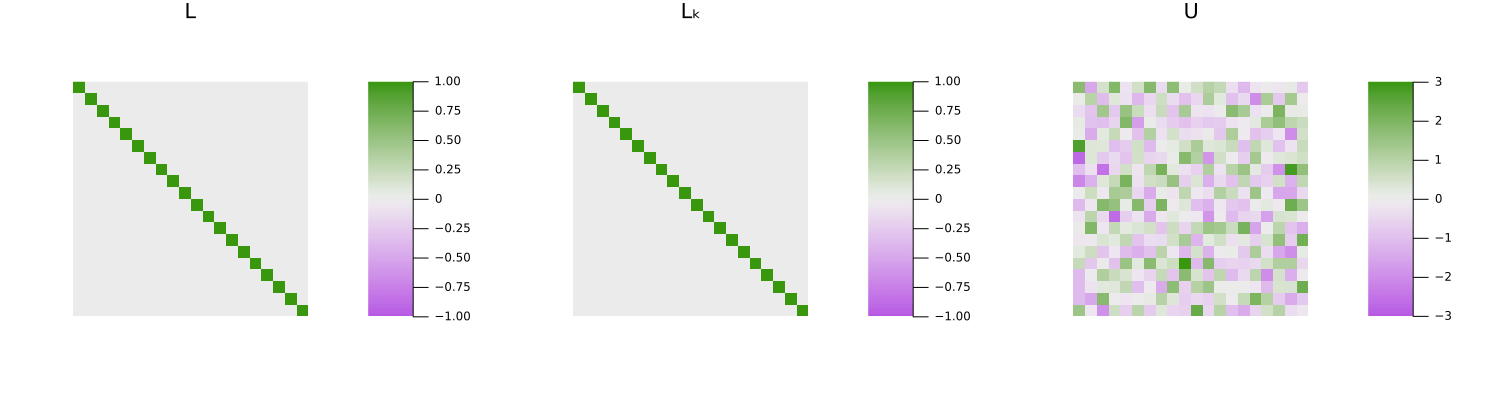

In [8]:
anim = Animation()
m = 20
A = randn(m,m)
U = copy(A)
LU = lu(A, NoPivot())
scale = max(norm(A,Inf),norm(LU.L,Inf),norm(LU.U,Inf))
L = Matrix(1.0I,m,m)
function plot_mats(L,Lₖ,U)
    l_scale = norm(L, Inf)
    k_scale = norm(Lₖ, Inf)
    u_scale = norm(U, Inf)
    l_plot = imshow(L, clim=(-l_scale,l_scale), title="L")
    k_plot = imshow(Lₖ, clim=(-k_scale, k_scale), title="Lₖ")
    u_plot = imshow(U, clim=(-u_scale, u_scale), title="U")
    p = plot(l_plot, k_plot, u_plot, layout=(1,3), size=(1500,400))
    return p
end
frame(anim,plot_mats(L,L,U))
for k in 1:(m-1)
    Lₖ = Matrix(1.0I,m,m)
    Lₖ[(k+1):m,k] = - LU.L[(k+1):m,k]
    L[(k+1):m,k] = LU.L[(k+1):m,k]
    U = L \ A
    frame(anim,plot_mats(L,Lₖ,U))
end
frame(anim,plot_mats(L,Matrix(1.0I,m,m),U))
gif(anim, "lu.gif", fps=0.5)

This is clearly unstable.

$\kappa(L)$ and $\kappa(U)$ may be arbitrarily large compared to $\kappa(A)$.

$$\large \begin{bmatrix}0 & 1 \\ 1 & 0\end{bmatrix}$$

- No LU factorization

$$\begin{bmatrix} \epsilon & 1 \\ 1 & 0 \end{bmatrix} = \begin{bmatrix} 1 & 0 \\ \epsilon^{-1} & 1 \end{bmatrix} \begin{bmatrix} \epsilon & 1 \\ 0 & -\epsilon^{-1}\end{bmatrix}$$

- Arbitrarily large factors

## Pivoting

### Terminology: the pivot

the entry ($x_{kk}$) used to scale the subtraction of one row from another

$$
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & \boldsymbol{x_{kk}} & \bullet & \bullet & \bullet \\
0 & \circ & \circ & \circ & \circ \\
0 & \circ & \circ & \circ & \circ \\
0 & \circ & \circ & \circ & \circ \\
\end{bmatrix}
\quad
\longrightarrow
\quad
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & x_{kk} & \circ & \circ & \circ \\
0 & \boldsymbol{0} & \bullet & \bullet & \bullet \\
0 & \boldsymbol{0} & \bullet & \bullet & \bullet \\
0 & \boldsymbol{0} & \bullet & \bullet & \bullet \\
\end{bmatrix}
$$


### Pivoting

Permuting rows / columns to make a different entry the pivot

$$
\underbrace{P_{i \leftrightarrow k}}_{\text{row perm.}}
\begin{bmatrix}
\circ & \bullet & \circ & \bullet & \circ \\
\boldsymbol{0} & \bullet & \bullet & \bullet & \bullet \\
0 & \bullet & \circ & \bullet & \circ \\
0 & \bullet & \circ & \bullet & \circ \\
\boldsymbol{0} & \bullet & \bullet & \boldsymbol{x_{ij}} & \bullet \\
\end{bmatrix}
\underbrace{P_{j \leftrightarrow k}}_{\text{col. perm.}}
\quad
\longrightarrow
\quad
\begin{bmatrix}
\circ & \bullet & \circ & \bullet & \circ \\
\boldsymbol{0} & \boldsymbol{x_{ij}} & \bullet & \bullet & \bullet \\
0 & \bullet & \circ & \bullet & \circ \\
0 & \bullet & \circ & \bullet & \circ \\
\boldsymbol{0} & \bullet & \bullet & \bullet & \bullet \\
\end{bmatrix}
$$

- Necessary in exact arithmetic in exact arithmetic if $x_{kk} = 0$

- Numerically, choosing **the largest available $|x_{ij}|$** keeps the growth of entries in $L$ and $U$ under control.

### Which entries are available?

- To keep the triangular structure already constructed, $x_{ij} \in A_{k:m,k:m}$

$$
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & \bullet & \bullet & \bullet & \bullet \\
0 & \bullet & \bullet & \bullet & \bullet \\
0 & \bullet & \bullet & \bullet & \bullet \\
0 & \bullet & \bullet & \bullet & \bullet \\
\end{bmatrix}
$$

Considering all of these entries is **complete pivoting:**

- Requires $\sim (m-k+1)^2$ comparisons in iteration $k$ ($\sim \frac{1}{3} m^3$ total)

### Full pivoting: row and column permutation matrices must be accumulated each iteration

$$
L_{m-1} P_{m-1} L_{m-2} P_{m-2} \cdots L_1 P_1 A Q_1 \cdots Q_{m-2} Q_{m-1} = U
$$

### Partial Pivoting

Only consider pivots in the current column

$$
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & \bullet & \circ & \circ & \circ \\
0 & \bullet & \circ & \circ & \circ \\
0 & \bullet & \circ & \circ & \circ \\
0 & \bullet & \circ & \circ & \circ \\
\end{bmatrix}
$$

**Pivot selection:** $i = \arg\max_{i\geq k} |x_{ik}|$

$$
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & \bullet & \circ & \circ & \circ \\
0 & \bullet & \circ & \circ & \circ \\
0 & \boldsymbol{x_{ik}} & \circ & \circ & \circ \\
0 & \bullet & \circ & \circ & \circ \\
\end{bmatrix}
$$

**Row interchange**

$$
\underbrace{P_{i \leftrightarrow k}}_{P_k}
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & \bullet & \bullet & \bullet & \bullet \\
0 & \circ & \circ & \circ & \circ \\
0 & \boldsymbol{x_{ik}} & \bullet & \bullet & \bullet \\
0 & \circ & \circ & \circ & \circ \\
\end{bmatrix}
=
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & \boldsymbol{x_{ik}} & \bullet & \bullet & \bullet \\
0 & \circ & \circ & \circ & \circ \\
0 & \bullet & \bullet & \bullet & \bullet \\
0 & \circ & \circ & \circ & \circ \\
\end{bmatrix}
$$

**Elimination**

$$
\underbrace{(I + \ell_k e_k^*)}_{L_k}
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & \boldsymbol{x_{ik}} & \circ & \circ & \circ \\
0 & \circ & \circ & \circ & \circ \\
0 & \circ & \circ & \circ & \circ \\
0 & \circ & \circ & \circ & \circ \\
\end{bmatrix}
=
\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
0 & \boldsymbol{x_{ik}} & \circ & \circ & \circ \\
0 & \boldsymbol{0} & \bullet & \bullet & \bullet \\
0 & \boldsymbol{0} & \bullet & \bullet & \bullet \\
0 & \boldsymbol{0} & \bullet & \bullet & \bullet \\
\end{bmatrix}
$$

### Partial pivoting: row permutation matrices must be accumulated

$$
L_{m-1} P_{m-1} L_{m-2} P_{m-2} \cdots L_1 P_1 A = U
$$

$$
L_{m-1} \tilde L_{m-2} \cdots \tilde L_1 P_{m-1} P_{m-2} \cdots P_1 A = U
$$

$$
\underbrace{
\left(
\begin{bmatrix}
2 & 1 & 1 \\ 4 & 3 & 3 \\ 8 & 7 & 9
\end{bmatrix}
\right.
}_{A}
,
\underbrace{
\left.
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1
\end{bmatrix}
\right)
}_{I}
$$

$$
\underbrace{
\begin{bmatrix}
0 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 0
\end{bmatrix}
}_{P_1}
\underbrace{
\left(
\begin{bmatrix}
2 & 1 & 1 \\ 4 & 3 & 3 \\ 8 & 7 & 9
\end{bmatrix}
\right.
}_{A},
\underbrace{
\left.
\begin{bmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1
\end{bmatrix}
\right)
}_{I}
=
\underbrace{
\left(
\begin{bmatrix}
8 & 7 & 9 \\ 4 & 3 & 3 \\ 2 & 1 & 1
\end{bmatrix}
\right.
}_{P_1 A},
\underbrace{
\left.
\begin{bmatrix}
0 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 0
\end{bmatrix}
\right)
}_{P_1}
$$

$$
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\ -\frac{1}{2} & 1 & 0 \\ -\frac{1}{4} & 0 & 1
\end{bmatrix}
}_{L_1}
\underbrace{
\left(
\begin{bmatrix}
8 & 7 & 9 \\ 4 & 3 & 3 \\ 2 & 1 & 1
\end{bmatrix}
\right.
}_{P_1 A},
\underbrace{
\left.
\begin{bmatrix}
0 & 0 & 1 \\ 0 & 1 & 0 \\ 1 & 0 & 0
\end{bmatrix}
\right)
}_{P_1}
=
\underbrace{
\left(
\begin{bmatrix}
8 & 7 & 9 \\ 0 & -\frac{1}{2} & -\frac{3}{2} \\ 0 & -\frac{3}{4} & -\frac{5}{4}
\end{bmatrix}
\right.
}_{L_1 P_1 A},
\underbrace{
\left.
\begin{bmatrix}
0 & 0 & 1 \\ 0 & 1 & -\frac{1}{2} \\ 1 & 0 & -\frac{1}{4}
\end{bmatrix}
\right)
}_{L_1 P_1}
$$

$$
\underbrace{
\left(
\begin{bmatrix}
8 & 7 & 9 \\ 0 & -\frac{3}{4} & -\frac{5}{4} \\ 0 & 0 & -\frac{2}{3}
\end{bmatrix}
\right.
}_{L_2 P_2 L_1 P_1 A = U},
\underbrace{
\left.
\begin{bmatrix}
0 & 0 & 1 \\ 1 & 0 & -\frac{1}{4} \\ -\frac{2}{3} & 1 & -\frac{1}{3}
\end{bmatrix}
\right)
}_{L_2 P_2 L_1 P_1}
$$

The permutations and the triangular factors can be disentangled:

$$
\underbrace{
\begin{bmatrix}
0 & 0 & 1 \\ 1 & 0 & -\frac{1}{4} \\ -\frac{2}{3} & 1 & -\frac{1}{3}
\end{bmatrix}
}_{L_2 P_2 L_1 P_1}
=
\underbrace{
\begin{bmatrix}
1 & 0 & 0 \\
-\frac{1}{4} & 1 & 0 \\
-\frac{1}{3} & -\frac{2}{3} & 1 \\
\end{bmatrix}
}_{L^{-1}}
\underbrace{
\begin{bmatrix}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0
\end{bmatrix}
}_{P}
$$

## $P_{k+1}$ and $L_k$ can move past each other

$$P_{(k+1):m,(k+1):m}(I + \ell_{k} e_k^*)$$

$$= P_{(k+1):m,(k+1):m} + \underbrace{(P_{(k+1):m,(k+1):m}\ell_{k})}_{\tilde{\ell}_k} e_k^*$$

$\tilde{\ell}_k$ still has zeros for all $1 \leq i \leq k$

$$= P_{(k+1):m,(k+1):m} + \underbrace{(P_{(k+1):m,(k+1):m}\ell_{k})}_{\tilde{\ell}_k} \underbrace{e_k^*P_{(k+1):m,(k+1):m}^*}_{= e_k^*} P_{(k+1):m,(k+1):m}$$

$$= (I + \tilde{\ell}_k e_k^*))P_{(k+1):m,(k+1):m}$$

### Gaussian Elimination with Partial Pivoting $\Leftrightarrow$ PA = LU factorization

$$ \large PA = LU $$

- $P$: Permutation matrix
- $A$: Any square matrix (usually nonsingular)
- $L$: Unit lower triangular, with values is magnitude $\leq 1$ below the diagonal
- $U$: Upper triangular